# Tidying up an ONS data series for Jupyter



In [1]:
from bs4 import BeautifulSoup
import re
import requests

ons_file = requests.get('https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/datasets/vacanciesbyindustryvacs02')

print(ons_file)

<Response [200]>


In [2]:
soup = BeautifulSoup(ons_file.content)
candidate_count = 0

for link in soup.findAll('a', {'href': re.compile('20[0-9][0-9]')}):
    if 'xls' in link.get('href'):
        target_file_addr = 'https://www.ons.gov.uk' + link.get('href')
        candidate_count += 1

if candidate_count == 0:
    print("Couldn't find xls link in web page.")
elif candidate_count > 1:
    print('Found too many possible data files (containing "xls") on web page.')

print('Fetching this file:')
print(target_file_addr)

xls_file = requests.get(target_file_addr).content


Fetching this file:
https://www.ons.gov.uk/file?uri=%2femploymentandlabourmarket%2fpeoplenotinwork%2funemployment%2fdatasets%2fvacanciesbyindustryvacs02%2fcurrent/vacs02jun2020.xls


In [3]:
import pandas as pd
import numpy as np

levels = pd.read_excel(xls_file, 'Levels')
# drop second column
levels.drop(levels.columns[[1]], axis = 1, inplace=True)
# remove tail rows
levels.drop(levels.tail(11).index, inplace=True)
# remove header rows
levels.drop([0,1,3,4,5,6], inplace=True)
# header
levels.columns = levels.iloc[0]
levels.columns.name = ''
levels.drop([2], inplace=True)
levels.rename(columns={'SIC 2007 sections':'Three months ending',
                       'All vacancies1 ':'All vacancies',
                       'Manu-    facturing':'Manufacturing',
                       'Electricity, gas, steam & air conditioning supply2':'Electricity, gas, steam & air conditioning supply',
                       'Construc-tion':'Construction',
                       'Administra-tive & support service activities':'Administrative & support service activities'},
              inplace=True)
# index
levels.index = np.arange(1, len(levels) + 1)

levels['Three months ending'] = levels['Three months ending'].str.split("-").str[1]
print(levels)


    Three months ending All vacancies Mining & quarrying Manufacturing  \
1              Jun 2001           680                  2            75   
2              Jul 2001           673                  2            75   
3              Aug 2001           661                  1            73   
4              Sep 2001           661                  1            71   
5              Oct 2001           637                  1            68   
..                  ...           ...                ...           ...   
224            Jan 2020           807                  2            55   
225            Feb 2020           818                  2            56   
226            Mar 2020           796                  1            52   
227            Apr 2020           641                  1            41   
228            May 2020           476                  1            32   

    Electricity, gas, steam & air conditioning supply  \
1                                                   2 

In [4]:
ratios = pd.read_excel(xls_file, 'Ratios')
# drop second column
ratios.drop(ratios.columns[[1]], axis = 1, inplace=True)
# remove tail rows
ratios.drop(ratios.tail(9).index, inplace=True)
# remove header rows
ratios.drop([0,1,3,4,5,6], inplace=True)
# header
ratios.columns = ratios.iloc[0]
ratios.columns.name = ''
ratios.drop([2], inplace=True)
ratios.rename(columns={'SIC 2007 sections':'Three months ending',
                       'All vacancies1 ':'All vacancies',
                       'Manu-    facturing':'Manufacturing',
                       'Electricity, gas, steam & air conditioning supply2':'Electricity, gas, steam & air conditioning supply',
                       'Construc-tion':'Construction',
                       'Administra-tive & support service activities':'Administrative & support service activities',
                       'Accomoda-tion & food service activities':'Accommodation & food service activities'},
              inplace=True)

ratios['Three months ending'] = ratios['Three months ending'].str.split("-").str[1]
# index
ratios.index = np.arange(1, len(ratios) + 1)
print(ratios)

    Three months ending All vacancies Mining & quarrying Manufacturing  \
1              Jun 2001           2.6                2.4           2.2   
2              Jul 2001           2.5                2.4           2.2   
3              Aug 2001           2.5                2.2           2.2   
4              Sep 2001           2.5                2.2           2.1   
5              Oct 2001           2.4                  2             2   
..                  ...           ...                ...           ...   
224            Jan 2020           2.6                3.1           2.2   
225            Feb 2020           2.7                2.9           2.2   
226            Mar 2020           2.6                2.7           2.1   
227            Apr 2020           2.1                2.3           1.6   
228            May 2020           1.6                1.7           1.3   

    Electricity, gas, steam & air conditioning supply  \
1                                                   2 

Everything above this is dataframe prep. Additional things that might be worthwile:
- generating numerical values for dates
- generating averages or trends for individual columns
- pulling in population data to get per-capita numbers for levels

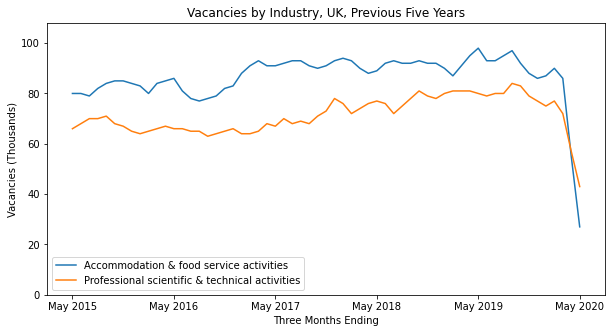

In [5]:
import matplotlib.pyplot as plt

five_years = levels[-61:]
afs = five_years['Accomodation & food service activities']
pst = five_years['Professional scientific & technical activities']


plt.figure(figsize=(10,5))
plt.ylim(0, afs.max()+10)
plt.ylabel('Vacancies (Thousands)')
plt.xlabel('Three Months Ending')
plt.title('Vacancies by Industry, UK, Previous Five Years')
plt.plot(afs, label='Accommodation & food service activities')
plt.plot(pst, label='Professional scientific & technical activities')
plt.xticks([168, 180, 192, 204, 216, 228],
           ['May 2015', 'May 2016', 'May 2017', 'May 2018', 'May 2019', 'May 2020'])
plt.legend()
